<a href="https://colab.research.google.com/github/akhavan12/discrete_covid_model/blob/master/Discrete_ver_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from ipywidgets import FloatSlider, IntSlider
pd.options.display.max_rows = 999
#https://github.com/DataHerb/dataset-covid-19/tree/master/csse_covid_19_time_series

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df[(df['Country/Region']=='France') ]['Province/State'].values

array(['French Guiana', 'French Polynesia', 'Guadeloupe', 'Mayotte',
       'New Caledonia', 'Reunion', 'Saint Barthelemy', 'St Martin',
       'Martinique', nan, 'Saint Pierre and Miquelon'], dtype=object)

In [0]:
def get_actual_ts(key='confirmed',country='Italy',rolling=4,population=60_000_000):
  """
    retrive informaton from actual cases database
    Parameters: 
    key (str): "confirmed", "recovered" or "dead"
    country (str): defult is italy (not case sensetive)
    rolling (int): rolling average for the daily cases
  
    Returns: 
    pandas dataframe: based on the type of the key
  
  """
 
  if key == "confirmed":
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
  elif key == "recovered":
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
  elif key == "dead":
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
  else:
    return -1


  df_=df[(df['Country/Region'].str.lower()==country.lower()) & (df['Province/State'].isnull())].T  
  df_ = df_.iloc[4:]
  df_ = df_.set_index(pd.to_datetime(df_.index))
  df_.columns=['cumulative']
  df_['daily'] = df_['cumulative'] - df_['cumulative'].shift(1).fillna(0)
  df_['rolling'] = df_['daily'].rolling(rolling).mean().fillna(0)
  df_['cumulative_percent']= (df_['cumulative'] / population) * 100
  return df_


## Live Data

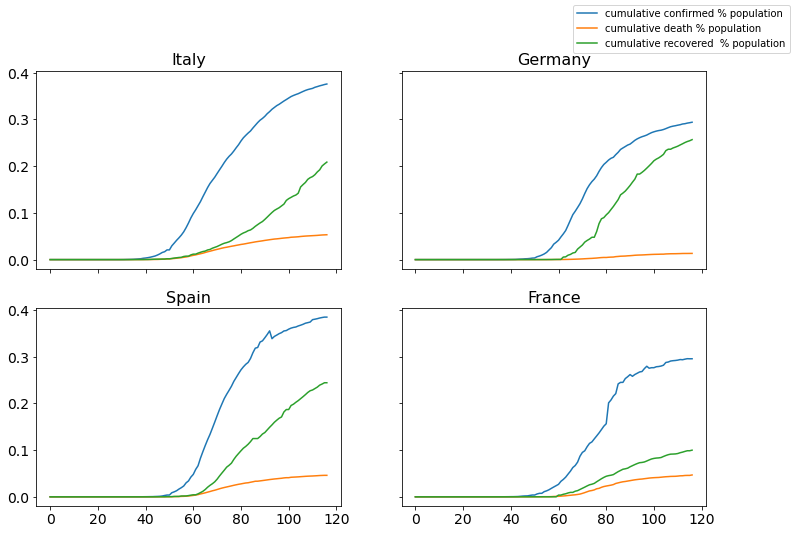

In [390]:

def country_situation(country='Italy',population=60_000_000):
  df_confirmed=get_actual_ts(key='confirmed',country=country)
  df_death=get_actual_ts(key='dead',country=country)
  df_recovered=get_actual_ts(key='recovered',country=country)

  act_confirmed = df_confirmed['cumulative_percent'].values
  act_death = df_death['cumulative_percent'].values
  act_recovered =  df_recovered['cumulative_percent'].values
  return [act_confirmed,act_death,act_recovered]

italy_data = country_situation(country = 'Italy',population = 60_000_000)
germany_data = country_situation(country = 'Germany',population = 83_000_000)
spain_data = country_situation(country = 'Spain',population = 46_000_000)
france_data = country_situation(country = 'France',population = 65_000_000)



f,axa = plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=True)
ax=axa.ravel()
ax[0].plot(italy_data[0],label='cumulative confirmed % population')
ax[0].plot(italy_data[1],label='cumulative death % population')
ax[0].plot(italy_data[2],label='cumulative recovered  % population')
ax[0].set_title('Italy',fontsize=16)
ax[0].tick_params(labelsize=14)


ax[1].plot(germany_data[0],label=None)
ax[1].plot(germany_data[1],label=None)
ax[1].plot(germany_data[2],label=None)
ax[1].set_title('Germany',fontsize=16)
ax[1].tick_params(labelsize=14)


ax[2].plot(spain_data[0],label=None)
ax[2].plot(spain_data[1],label=None)
ax[2].plot(spain_data[2],label=None)
ax[2].set_title('Spain',fontsize=16)
ax[2].tick_params(labelsize=14)


ax[3].plot(france_data[0],label=None)
ax[3].plot(france_data[1],label=None)
ax[3].plot(france_data[2],label=None)
ax[3].set_title('France',fontsize=16)

ax[3].tick_params(labelsize=14)


f.legend()

![alt text](https://raw.githubusercontent.com/akhavan12/discrete_covid_model/master/Model_Discrete_v4_new.svg)


In [0]:
prc = 2 ## Precision for the calculations
T = []
def set_probs_Other_Exposed(Probs):
  ### Other_Exp,Other_Symp
  Probs["Other_Exposed"] = [
          [1.00,0.00], #0
          [0.80,0.20], #1
          [0.60,0.40], #2
          [0.30,0.70], #3
          [0.00,1.00], #4
  ]
def set_probs_Other_Symp(Probs):
  ### Other_Symp,Susceptible   
  Probs['Other_Symp'] =[[0.80,  0.20],
                        [0.50,  0.50 ], 
                        [0.00,  1.00]]      

def set_probs_M(Probs):
  ### M,R,Severe
  """  Probs["M"] = [
          [1.00,0.00,0.00], #0
          [0.80,0.00,0.20], #1
          [0.60,0.00,0.40], #2
          [0.50,0.10,0.40], #3
          [0.40,0.40,0.20], #4
          [0.30,0.30,0.40], #5
          [0.30,0.50,0.20], #6
          [0.30,0.50,0.20], #7
          [0.30,0.50,0.20], #8
          [0.30,0.50,0.20], #9
          [0.30,0.50,0.20], #10 
          [0.30,0.50,0.20], #11
          [0.20,0.60,0.20], #12 
          [0.00,0.00,1] #13
          ]"""

  def m_at_day(num_days = 14,alpha_r = .8):
      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm
      Tdays = np.arange(num_days) #x
      Top = 1
      Buttom = 0
      v50= num_days/2
      slope= 1.8
      m_to_m = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))
      m_to_r = alpha_r*(1 - m_to_m)
      m_to_v = 1 - (m_to_m+m_to_r)
      return pd.DataFrame({'m_to_m': m_to_m, 'm_to_r' :m_to_r,'m_to_v': m_to_v})
  
  Probs["M"] = m_at_day(num_days = 14,alpha_r = .8).values

def set_probs_MU(Probs):
  ### MU,R
  Probs["M_undiagnosed"] = [
          [1.00,0.00], #0
          [0.80,0.20], #1
          [0.60,0.40], #2
          [0.50,0.50], #3
          [0.40,0.60], #4
          [0.30,0.70], #5
          [0.30,0.70], #6
          [0.30,0.70], #7
          [0.30,0.70], #8
          [0.30,0.70], #9
          [0.30,0.70], #10 
          [0.30,0.70], #11
          [0.30,0.70], #12 
          [0.00,1.00]  #13
  ]

def set_probs_Severe(Probs):
  ### Severe,R,V,D
  """Probs["Severe"] = [
          [0.70,0.10,0.10,0.10], #0
          [0.70,0.10,0.10,0.10], #1
          [0.70,0.10,0.10,0.10], #2
          [0.40,0.10,0.30,0.20], #3
          [0.30,0.30,0.30,0.20], #4
          [0.10,0.40,0.30,0.20], #5
          [0.10,0.40,0.30,0.20], #6
          [0.10,0.40,0.30,0.20], #7
          [0.10,0.40,0.30,0.20], #8
          [0.10,0.40,0.30,0.20], #9
          [0.10,0.40,0.30,0.20], #10
          [0.10,0.40,0.30,0.20], #11
          [0.10,0.40,0.30,0.20], #12
          [0.00,0.00,1.00,0.00]  #13
        ]"""

  def w_at_day(num_days = 14,alpha_r = .2,alpha_v = .2):
      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm
      Tdays = np.arange(num_days) #x
      Top = 1
      Buttom = 0
      v50= num_days/3
      slope= 1.8
      w_to_w = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))

      w_to_r = alpha_r*(1 - w_to_w)
      w_to_v = alpha_v*(1 - w_to_w)
      w_to_d = 1 - (w_to_w+w_to_r+w_to_v)
      return pd.DataFrame({'w_to_w': w_to_w, 
                           'w_to_r' :w_to_r, 
                           'w_to_v' :w_to_v,
                           'w_to_d': w_to_d})
  Probs["Severe"] = w_at_day(num_days = 14,alpha_r = .2,alpha_v = .2).values

def set_probs_ventilator(Probs):
  ### V,R,D 
  """Probs["ventilator"] = [
          [0.50,0.45,0.05], #0
          [0.40,0.55,0.05], #1
          [0.40,0.55,0.05], #2
          [0.30,0.65,0.05], #3
          [0.40,0.20,0.30], #6
          [0.40,0.20,0.30], #7
          [0.40,0.20,0.30], #8
          [0.10,0.10,0.80], #9
          [0.10,0.10,0.80], #10
          [0.10,0.10,0.80], #11
          [0.10,0.10,0.80], #12
          [0.00,0.00,1.00]  #13
          ]""" 

  def v_at_day(num_days = 20,alpha_r = .2):
      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm
      Tdays = np.arange(num_days) #x
      Top = 1
      Buttom = 0
      v50= num_days/2
      slope= 1.8
      v_to_v = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))
      v_to_r = alpha_r*(1 - v_to_v)
      v_to_d = 1 - (v_to_v+v_to_r)
      return pd.DataFrame({'v_to_v': v_to_v, 'v_to_r' :v_to_r,'v_to_d': v_to_d})
  Probs["ventilator"] = v_at_day(20).values

def set_probs_Symp(Probs):
  ### Symp,M   0: not tested, 1: tested positive ,2: tested negative
  Probs['Symp'] =[[0.20,  0.80 , 0.00 ], #0 Testing and + cases go to Mild cases , negative cases go back to Healthy
                  [0.00,  0.60 , 0.40 ]]      #1 ###  all remainings go to Mild cases 

def set_probs_E(Probs):
  ### E,Symp
  """Probs["E"] = [[1.00,0.00], #0 ### first day of exposure
                [0.50,0.50], #1       
                [0.40,0.60], #2 
                [0.30,0.70], #4
                [0.20,0.80], #5
                [0.10,0.90], #6
                [0.05,0.95], #7
                [0.05,0.95], #8
                [0.05,0.95], #9
                [0.05,0.95], #10
                [0.05,0.95], #11
                [0.05,0.95], #12
                [0.05,0.95], #13
                [0.05,0.95], #14
                [0.05,0.95], #15
                [0.05,0.95], #16
                [0.05,0.95], #17
                [0.05,0.95], #18
                [0.05,0.95], #19
                [0.00,1.00]  #20
                ]"""

  def e_at_day(num_days = 20):
      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm
      Tdays = np.arange(num_days) #x
      Top = 1
      Buttom = 0
      v50= 5
      slope= 1.8
      e_to_m = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))
      e_to_e = 1 - (v_to_v+v_to_r)
      return pd.DataFrame({'e_to_e': e_to_e, 'e_to_m' :e_to_m})
  Probs["E"] = e_at_day(20).values

P={}
EXP_Other =[]
MU = []     ## Mild undiagnosed
E = []       ## Exposed 
H = []      ## Healthy (susceptible)
Symp = []   ## Symptomatic
M = []      ## Mild Symptomatic
W = []      ## Severe
V = []       ## Ventilator
R = []      ## Recovered
D = []      ## Dead
add_M = []  
add_sym = [] 
add_E = [] 
add_Severe = []
add_ventilator = []


def calculate(initial_population = 1000,initial_exposed=100,lenght_t = 50,B=.1):
  global P
  global EXP_Other

  global MU     ## Mild undiagnosed
  global E      ## Exposed 
  global H      ## Healthy (susceptible)
  global Symp   ## Symptomatic
  global M      ## Mild Symptomatic
  global W      ## Severe
  global V      ## Ventilator
  global R      ## Recovered
  global D      ## Dead
  global add_M  
  global add_sym 
  global add_E 
  global add_Severe
  global add_ventilator
  global Track_M

  Beta = np.repeat(B,lenght_t)

  Track_M = []

  P={}
  set_probs_Severe(P)
  set_probs_ventilator(P)
  set_probs_Symp(P)
  set_probs_E(P)
  set_probs_M(P)
  #### Other deiseases variables: NOT COVID
  set_probs_Other_Exposed(P)
  set_probs_Other_Symp
  EXP_Other = np.zeros((len(P['Other_Exposed']),lenght_t))
  #### COVID variables
  set_probs_MU(P) ### undiagnosed MILD COVID
  MU = np.zeros((len(P['M_undiagnosed']),lenght_t))
  E = np.zeros((len(P['E']),lenght_t))
  Symp = np.zeros((len(P['Symp']),lenght_t))
  M = np.zeros((len(P['M']),lenght_t))
  W = np.zeros((len(P['Severe']),lenght_t))
  V = np.zeros((len(P['ventilator']),lenght_t))
  R = np.zeros(lenght_t)
  D = np.zeros(lenght_t)
  H = np.zeros(lenght_t)

  add_M = []
  add_sym = []
  add_E = []
  add_Severe = []
  add_ventilator = []
  ############################################################
  ############################################################
  ############################################################
  print(E.shape)
  E[0,0] = initial_exposed
  M[0,0] = 0
  ############################################################
  ############################################################
  ############################################################
  H[0] = initial_population - E[0,0]



  for t in range(lenght_t-1):
    R[t+1] = R[t]
    D[t+1] = D[t]

    for state in range(len(P['E'])):
      try:
        E[state+1,t+1] =  np.round(E[state,t] * P["E"][state][0],prc) ## Stay exposed conditions
      except:
        pass
      Symp[0,t+1] = np.round(Symp[0,t+1] + E[state,t] * P["E"][state][1],prc)  ## at time t+1 add the portion of the Exposed to the symptomatic
    ### Symptomatic states Tests take place here
    #################################################                            0      1 
    Symp[1,t+1] = np.round(Symp[0,t] * P["Symp"][0][0],prc)         ### P["Symp"][0][0] ==> [[0,1]  [0,1]]
                                                      ###                      |   |   |  |   
                                                      ###         next day    Symp M
                                                      ###         next day             Symp M
    ### from Symptomatic to mild --> where testing also happens
    M[1,t+1] = np.round(Symp[0,t] * P["Symp"][0][1],prc)                 ### From state 0 to Mild state 0
    M[1,t+1] = np.round(M[1,t+1] +  Symp[1,t] * P["Symp"][1][1],prc)     ### From state 1 to Mild state 0

    Track_M.append(M[:,t])

    MU[0,t+1] = np.round(Symp[0,t] * P["Symp"][0][2],prc)                 ### From state 0 to Mild state 0
    MU[0,t+1] = np.round(MU[0,t+1] +  Symp[1,t] * P["Symp"][1][2],prc)     ### From state 1 to Mild state 0


    #################################################
    #add_sym.append(Symp[0,t] - (Symp[0,t] * P["Symp"][0][0]+Symp[0,t] * P["Symp"][0][1]))
    #add_sym.append(Symp[1,t] -  Symp[1,t] * P["Symp"][1][1] )

    ### Mild cases are calculated in this section
    for state in range(1,len(P['M'])):
      ### M,R,Severe
      try:
        M[state+1,t+1] =  np.round(M[state,t] * P["M"][state][0],prc) ## from state= state --> to state+1
      except:
        pass
      R[t+1] = np.round(R[t+1] + M[state,t] * P["M"][state][1],prc) ## from Mild to recovered
      W[0,t+1] = W[0,t+1] + np.round(M[state,t] * P["M"][state][2],prc)

    ###############################################
    ### Un-diagnosed Mild 
    for state in range(0,len(P['M_undiagnosed'])):
      ### M,R,Severe
      try:
        MU[state+1,t+1] =  np.round(MU[state,t] * P["M_undiagnosed"][state][0],prc) ## from state= state --> to state+1
      except:
        pass

      R[t+1] = np.round(R[t+1] + MU[state,t] * P["M_undiagnosed"][state][1],prc) ## from undiagnosed_Mild to recovered
      #if MU[state,t] * P["M_undiagnosed"][state][1]>0:
        #print(state, t,':', MU[state,t] * P["M_undiagnosed"][state][1])

    ##########################################
    ### Severe Cases 

    for state in range(0,len(P['Severe'])):
    ### Severe,R,V,D
      try:
        W[state+1,t+1] =  np.round(W[state,t] * P["Severe"][state][0],prc)
      except:
        pass
      R[t+1] = np.round(R[t+1] + W[state,t] * P["Severe"][state][1],prc)

      if W[state,t] * P["Severe"][state][2]>0:
        V[0,t+1] = V[0,t+1] + np.round(W[state,t] * P["Severe"][state][2],prc)

      D[t+1] = D[t+1] + np.round(W[state,t] * P["Severe"][state][3],prc)

    ###########################################
    ### ventilator cases

    for state in range(0,len(P['ventilator'])):
    ### V,R,D 
      try: 
        V[state+1,t+1] = np.round( V[state,t] * P["ventilator"][state][0],prc)
      except:
        pass
      R[t+1] = R[t+1] + np.round(V[state,t] * P["ventilator"][state][1],prc)
      D[t+1] = D[t+1] + np.round(V[state,t] * P["ventilator"][state][2],prc)

    if H[t] >(H[t]/initial_population)  *  M[:,t].sum() * Beta[t]:
      E[0,t+1] = (H[t]/initial_population)  *  M[:,t].sum() * Beta[t]
      H[t+1]= H[t] - np.round(E[0,t+1])
    elif ((H[t]>0) & ((H[t]/initial_population)  *  M[:,t].sum() * Beta[t])):
      E[0,t+1] = H[t]

      H[t+1]= 0

(20, 100)


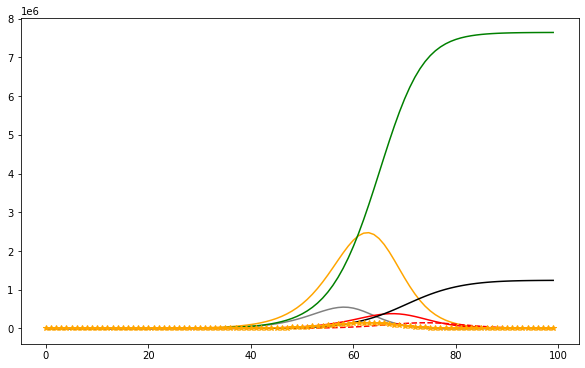

In [0]:
calculate(initial_population= 10_000_000,initial_exposed=100,B=.6,lenght_t=100)
f,ax=plt.subplots(figsize=(10,6))
ax.plot(E.sum(axis=0),color='gray',label = 'Incubation')
ax.plot(M.sum(axis=0),color='orange', label ='Mild')
ax.plot(W.sum(axis=0),color='red', label ='Severe')
ax.plot(V.sum(axis=0),'--',color='red', label ='Ventilator')
ax.plot(R,color='green', label = 'Recovered')
ax.plot(D,color='Black', label = 'Dead')
ax.plot(MU.sum(axis=0),'-*',color='orange', label ='Undiagnosed Mild')

## Comparison

## Fitting with actual data

In [0]:
Country = 'Italy'
Track_M = []

def Interactive_deriv(Population,initial_exposed,B,L,Delay,normalization_factor):


  ###############
  ##############

  calculate(initial_population=Population, initial_exposed=initial_exposed, lenght_t=L, B=B)


  f,axx = plt.subplots(1,2,figsize=(18,7))
  ax=axx.ravel()
  
  ax[0].plot(E.sum(axis=0),color='gray',label = 'Incubation')
  ax[0].plot(M.sum(axis=0),color='orange', label ='Mild')
  ax[0].plot(W.sum(axis=0),color='red', label ='Severe')
  ax[0].plot(V.sum(axis=0),'--',color='red', label ='Ventilator')

  ax[0].plot(R,color='green', label = 'Recovered')
  ax[0].plot(D,color='Black', label = 'Dead')
  ax[0].plot(MU.sum(axis=0),'-*',color='orange', label ='Undiagnosed Mild')


  df_actual_confirm = get_actual_ts(key="confirmed")
  df_actual_dead = get_actual_ts(key="dead")
  df_actual_recovered = get_actual_ts(key="recovered")

  #ax[0].plot(H,color='blue', label = 'Susceptible')


  #ax[0].plot(df_actual_dead['cumulative'].values[Delay:],color='blue',label = 'dead' )



  ax[1].plot(df_actual_confirm['rolling'].values[Delay:],label='Confirmed daily')
  ax[1].plot(df_actual_dead['cumulative'].values[Delay:],label = 'dead' )
  ax[1].plot(df_actual_recovered['cumulative'].values[Delay:], label = 'recovered')
  ax[1].tick_params(labelsize=14)
  ax[1].legend(fontsize=14)
  

  ax[0].tick_params(labelsize=14)
  ax[1].set_title('Italy')
  ax[0].legend(fontsize=14)


w = interactive(
    Interactive_deriv,
    Population = IntSlider(min=1000, max=50_000_000,   continuous_update=False,   step=1, value=10_000_000, description = 'Population'),
    initial_exposed = IntSlider(min=1, max=5000,   continuous_update=False,   step=1, value=100, description = 'initial_exposed'),
    B=        FloatSlider(min=0.11, max=1,     continuous_update=False, readout_format='.8f',   step=0.000001, value=.61, description = 'Beta'),
    L = IntSlider(min=10, max=200,     continuous_update=False,   step=1, value=120, description = 'length of simmulation'),
    Delay = IntSlider(min=1, max=50,   continuous_update=False,   step=1, value=1, description = 'Delay'),
    normalization_factor = IntSlider(min=1, max=1000,   continuous_update=False,   step=1, value=500, description = 'normalization_factor')
    )
w


interactive(children=(IntSlider(value=10000000, continuous_update=False, description='Population', max=5000000…

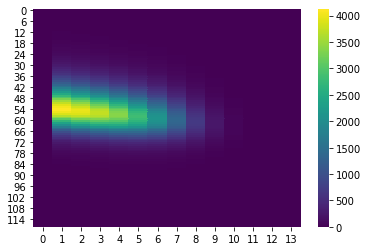

In [0]:
Track_M=np.asanyarray(Track_M)
df_Track_M=pd.DataFrame(Track_M)
sns.heatmap(Track_M,cmap='viridis',xl)

In [0]:
#sns.jointplot(Track_M)
positional=[]
m,n = Track_M.shape
for i in range(m):
  for j in range(n):
    positional.append([i,j,Track_M[i,j]])


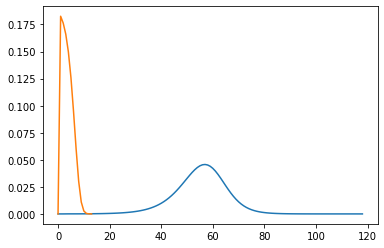

In [0]:
df_positions = pd.DataFrame(positional,columns=['x','y','val'])
#x = df_positions.groupby('x')['val'].sum()/df_positions.groupby('y')['val'].sum().sum()
Jy = pd.DataFrame(df_positions.groupby(['y'])['val'].sum()/df_positions.groupby(['y'])['val'].sum().sum())
Jx = pd.DataFrame(df_positions.groupby(['x'])['val'].sum()/df_positions.groupby(['x'])['val'].sum().sum())
plt.plot(Jx)
plt.plot(Jy)

## Formulizing transition Matrix

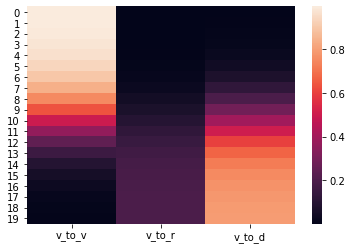

In [0]:
sns.heatmap(v_at_day_2(20))

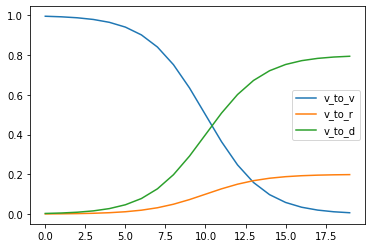

In [0]:
v_at_day_2(20).plot()

In [0]:
def v_at_day_2(num_days = 20,alpha_r = .2):
      ## https://www.graphpad.com/guides/prism/7/curve-fitting/reg_classic_boltzmann.htm
      Tdays = np.arange(num_days) #x
      Top = 1
      Buttom = 0
      v50= num_days/2
      slope= 1.8
      v_to_v = Top +  (Buttom - Top)/(1+ np.exp((v50 - Tdays)/slope))
      v_to_r = alpha_r*(1 - v_to_v)
      v_to_d = 1 - (v_to_v+v_to_r)
      return pd.DataFrame({'v_to_v': v_to_v, 'v_to_r' :v_to_r,'v_to_d': v_to_d})



v_at_day_2(20).values

array([[9.96148968e-01, 7.70206471e-04, 3.08082588e-03],
       [9.93307149e-01, 1.33857018e-03, 5.35428074e-03],
       [9.88392684e-01, 2.32146329e-03, 9.28585316e-03],
       [9.79942463e-01, 4.01150731e-03, 1.60460292e-02],
       [9.65554804e-01, 6.88903913e-03, 2.75561565e-02],
       [9.41463097e-01, 1.17073806e-02, 4.68295223e-02],
       [9.02227400e-01, 1.95545200e-02, 7.82180799e-02],
       [8.41130895e-01, 3.17738210e-02, 1.27095284e-01],
       [7.52336199e-01, 4.95327602e-02, 1.98131041e-01],
       [6.35423559e-01, 7.29152881e-02, 2.91661153e-01],
       [5.00000000e-01, 1.00000000e-01, 4.00000000e-01],
       [3.64576441e-01, 1.27084712e-01, 5.08338847e-01],
       [2.47663801e-01, 1.50467240e-01, 6.01868959e-01],
       [1.58869105e-01, 1.68226179e-01, 6.72904716e-01],
       [9.77725999e-02, 1.80445480e-01, 7.21781920e-01],
       [5.85369029e-02, 1.88292619e-01, 7.53170478e-01],
       [3.44451957e-02, 1.93110961e-01, 7.72443843e-01],
       [2.00575365e-02, 1.95988